Size of training set: 2076
Size of validation set: 259
Size of test set: 259
0.809134643777058
0.33613242696015894
0.6808439973631373
0.16720326925564308


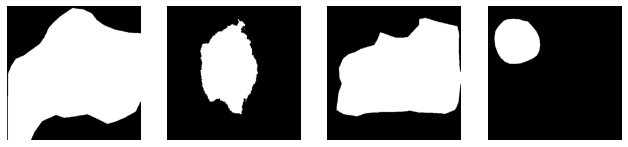

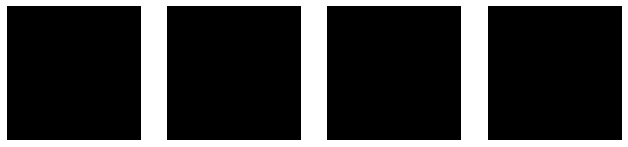

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob
import helper

#Getting the filenames for the masks and images, sorting them so corresponding mask match corresponding image
masks = sorted(glob.glob("D:/ISIC2018_Task1_Training_GroundTruth_x2/*.png"))
files = sorted(glob.glob("D:/ISIC2018_Task1-2_Training_Input_x2/*.jpg"))

#We split the data such that train data is 80%, validation and test data are 20%
train_images, train_masks, val_masks, val_images, test_masks, test_images = helper.split_data(files, masks, 0.2, 0.5)

print('Size of training set:', len(train_images))
print('Size of validation set:', len(val_images))
print('Size of test set:', len(test_images))

#We map the filenames and masks to data arrays and shuffle them
train_data = helper.shuffle_map_data(train_images, train_masks)
val_data = helper.shuffle_map_data(val_images, val_masks)
test_data = helper.shuffle_map_data(test_images, test_masks)
        
model = helper.unet()
model.compile(optimizer='adam',
             loss ='categorical_crossentropy',
             metrics=[helper.dice_coef, 'accuracy'])
#Predictions before training our model on the validation data
#The dice coefficients is printed in order for each image
helper.predictions(val_data, model)
    

In [7]:
history = model.fit(train_data.batch(32), epochs = 6, validation_data = val_data.batch(32))

Train for 65 steps, validate for 9 steps
Epoch 1/6
65/65 [==============================] - 76s 1s/step - loss: 0.5472 - dice_coef: 0.6729 - accuracy: 0.8058 - val_loss: 0.5656 - val_dice_coef: 0.7176 - val_accuracy: 0.7479
Epoch 2/6
65/65 [==============================] - 78s 1s/step - loss: 0.4288 - dice_coef: 0.7713 - accuracy: 0.8077 - val_loss: 0.3980 - val_dice_coef: 0.7551 - val_accuracy: 0.7479
Epoch 3/6
65/65 [==============================] - 77s 1s/step - loss: 0.3778 - dice_coef: 0.7766 - accuracy: 0.8077 - val_loss: 0.3816 - val_dice_coef: 0.7574 - val_accuracy: 0.7479
Epoch 4/6
65/65 [==============================] - 68s 1s/step - loss: 0.3414 - dice_coef: 0.8014 - accuracy: 0.8451 - val_loss: 0.2987 - val_dice_coef: 0.8105 - val_accuracy: 0.8933
Epoch 5/6
65/65 [==============================] - 58s 888ms/step - loss: 0.3209 - dice_coef: 0.8178 - accuracy: 0.8843 - val_loss: 0.2936 - val_dice_coef: 0.8191 - val_accuracy: 0.9107
Epoch 6/6
65/65 [========================

0.8939235397436377
0.9635200010572955
0.40720109383703856
0.8452266390986126
0.916003908069067
0.8725068752836889
0.9370253969407405
0.9790102863497359
0.7241735846794737
0.9126510778776004


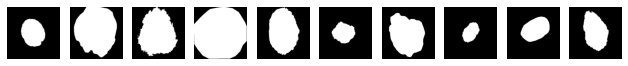

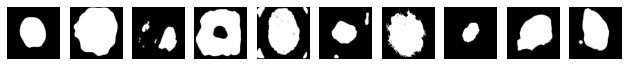

In [8]:
#Predictions on the test data
helper.predictions(test_data, model, 10)

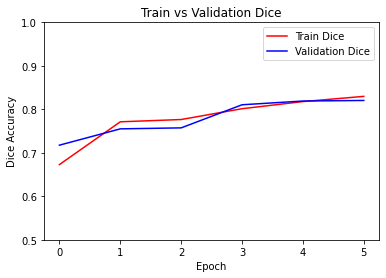

In [9]:
train_coef = history.history['dice_coef']
val_coef = history.history['val_dice_coef']


epochs = range(6)

plt.figure()
plt.plot(epochs, train_coef, 'r', label='Train Dice')
plt.plot(epochs, val_coef, 'b', label='Validation Dice')
plt.title('Train vs Validation Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Accuracy')
plt.ylim([0.5, 1])
plt.legend()
plt.show()

In [10]:
#Testing our model against Test set
results = model.evaluate(test_data.batch(32))

9/9 [==============================] - 1s 148ms/step - loss: 0.3174 - dice_coef: 0.7920 - accuracy: 0.8924


In [11]:
#We find the average dice coefficient for all the images in test data set using
#our model prediction
helper.average_dice(test_data, model)

0.8244336603103143
